# Deep Learning Project : Dialogue summarization

## Part 1 : Exploratory Data Analysis (EDA) 📈📈📈

### Objective 🏹

The SAMSum dataset consists of over 16,000 dialogue examples designed for the task of summarizing informal conversations, such as chat messages. This corpus allows models to generate concise, coherent summaries of multi-turn dialogues, helping refine AI’s ability to process and summarize human-like interactions. In dialogue summarization, models like T5 (Text-To-Text Transfer Transformer) and BART (Bidirectional and Auto-Regressive Transformers) achieve high accuracy by capturing nuanced context and summarizing effectively while handling the complexity of conversational flow.

### Libraries import 📚

In [21]:
import json
import nltk
import pyLDAvis
import ijson
import collections
import gensim
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from abbreviations_py.textes.abbreviator import fix, update_abbreviations
from cleantext import clean
from nltk.stem import porter, WordNetLemmatizer 
from nltk.corpus import stopwords
from collections import defaultdict
import pyLDAvis.gensim


### Functions definition 🧮

In [56]:
# Function to process JSON in chunks
def process_json_in_chunks(file_path):
    with open(file_path, 'r') as f:
        # Use ijson to parse items incrementally
        parser = ijson.items(f, 'item')
        for item in parser:
            yield item

def clean_text_remove_emoji(text):
    return clean(text, no_emoji=True)

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def preprocess_summary(df, stop):
    corpus=[]
    lem=WordNetLemmatizer()
    for summary in df['summary']:
        words=[w for w in word_tokenize(summary) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

def preprocess_dialogue(df, stop):
    corpus=[]
    lem=WordNetLemmatizer()
    for dialogue in df['dialogue']:
        words=[w for w in word_tokenize(dialogue) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [24]:
# File paths for three JSON files
train_json = './corpus/train.json'
test_json = './corpus/test.json'
val_json = './corpus/val.json'

# Initialize an empty list to hold the data for the DataFrame
data = []

# Process each file and append the data to the list
for file_path in [train_json, test_json, val_json]:
    for chunk in process_json_in_chunks(file_path):
        data.append(chunk)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

c:\Users\ksimotabudjifupa\AppData\Local\miniconda3\envs\summary_venv\lib\site-packages\ijson\compat.py:32: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probably, but not necessarily, means a file-like object has been opened in text
mode ('t') rather than binary mode ('b').

An automatic conversion is being performed on the fly to continue, but on the
other hand this creates unnecessary encoding/decoding operations that decrease
the efficiency of the system. In the future this automatic conversion will be
removed, and users will receive errors instead of this warning. To avoid this
problem make sure file-like objects are opened in binary mode instead of text
mode.

  warnings.warn(_str_vs_bytes_warning, DeprecationWarning)
c:\Users\ksimotabudjifupa\AppData\Local\miniconda3\envs\summary_venv\lib\site-packages\ijson\compat.py:32: DeprecationWarning: 
ijson works by reading bytes, but a string reader has been given instead. This
probab

In [26]:
df = df.drop(['id'],axis=1)
df = df.applymap(fix) # Remove abbreviations
df = df.applymap(clean_text_remove_emoji) # Remove emojis and emoticons
df.to_csv('./data.csv', sep=';',index=False)

In [4]:
df = pd.read_csv('./data.csv',sep=';')
df.head()

,summary,dialogue
0,amanda baked cookies and will bring jerry some...,amanda i baked cookies do you want some jerry ...
1,olivia and olivier are voting for liberals in ...,olivia who are you voting for in this election...
2,kim may try the pomodoro technique recommended...,tim hi what is up kim bad relatable feeling to...
3,edward thinks he is in love with bella rachel ...,edward rachel i think i am in ove with bella r...
4,sam is confused because he overheard rick comp...,sam hey overheard rick say something sam i do ...


In [27]:
df.shape

(16369, 2)

In [28]:
df = df.dropna()

<Axes: >

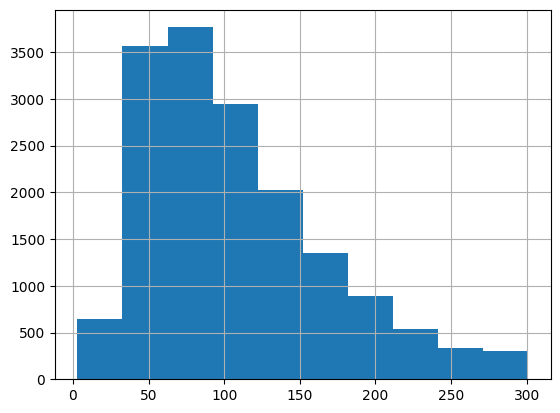

In [29]:
# number of characters present in each sentence of summary
df['summary'].str.len().hist()

<Axes: >

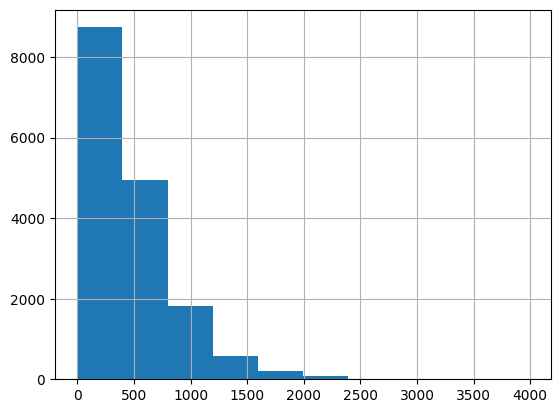

In [30]:
# number of characters present in each sentence of dialogue
df['dialogue'].str.len().hist()

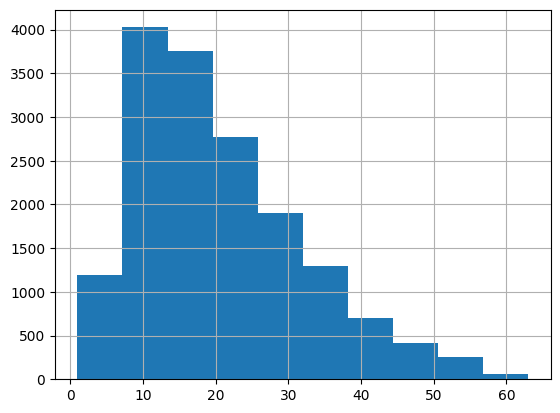

In [31]:
# Words count in summary
text = df['summary']
word_counts = text.str.split().map(len).hist()

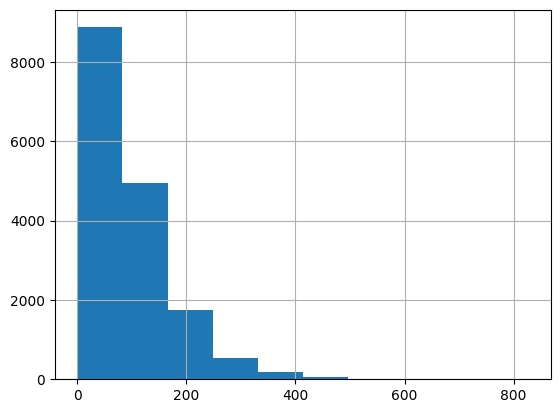

In [32]:
# Words count in dialogue
text = df['dialogue']
word_counts = text.str.split().map(len).hist()

<Axes: >

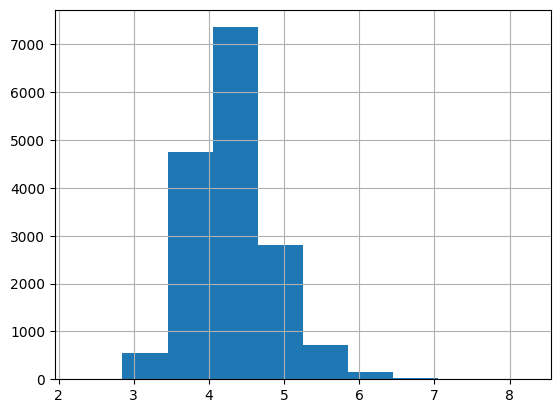

In [33]:
# Average word length in summary
df['summary'].str.split(). \
    apply(lambda x : [len(i) for i in x]). \
    map(lambda x: np.mean(x)). \
    hist()

c:\Users\ksimotabudjifupa\AppData\Local\miniconda3\envs\summary_venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ksimotabudjifupa\AppData\Local\miniconda3\envs\summary_venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: >

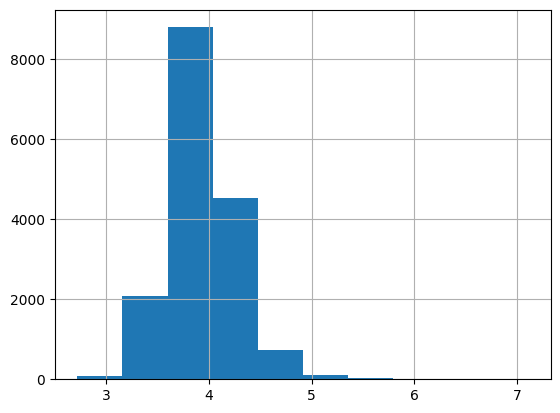

In [34]:
# Average word length in dialogue
df['dialogue'].str.split(). \
    apply(lambda x : [len(i) for i in x]). \
    map(lambda x: np.mean(x)). \
    hist()

In [35]:
# stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksimotabudjifupa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Summaries analysis

In [36]:
corpus=[]
new= df['summary'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

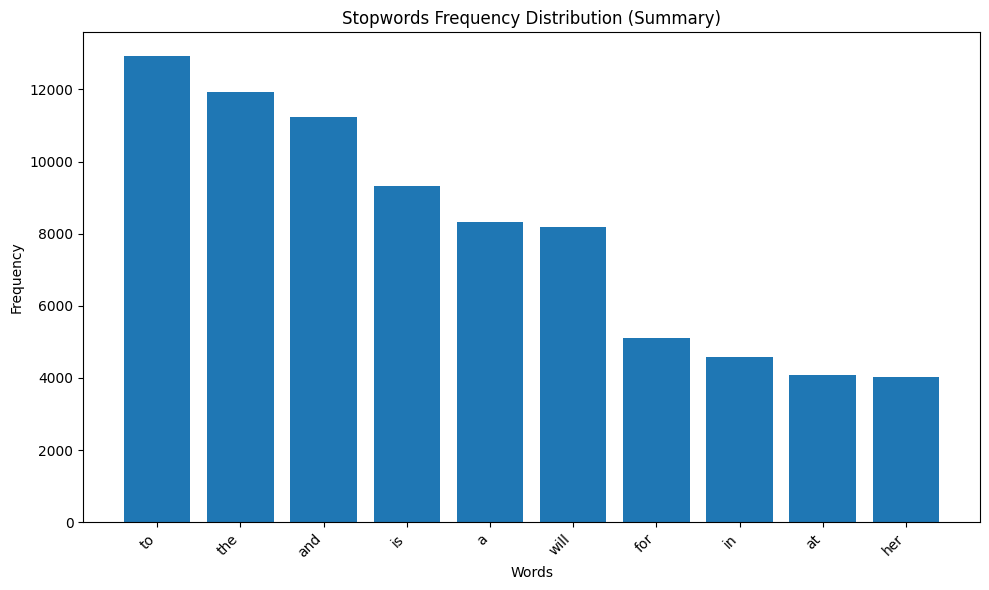

In [20]:
# Extract words and counts as separate lists
words = list(dic.keys())
counts = list(dic.values())

sorted_data = sorted(zip(words, counts), key=lambda x: x[1], reverse=True)
words, counts = zip(*sorted_data)

# Limit the number of words to plot (optional)
max_words_to_plot = 10  # You can adjust this value

words = words[:max_words_to_plot]
counts = counts[:max_words_to_plot]

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Stopwords Frequency Distribution (Summary)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`

<Axes: >

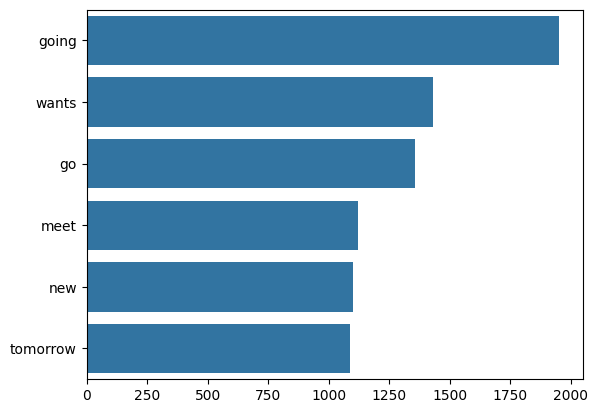

In [38]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`

<Axes: >

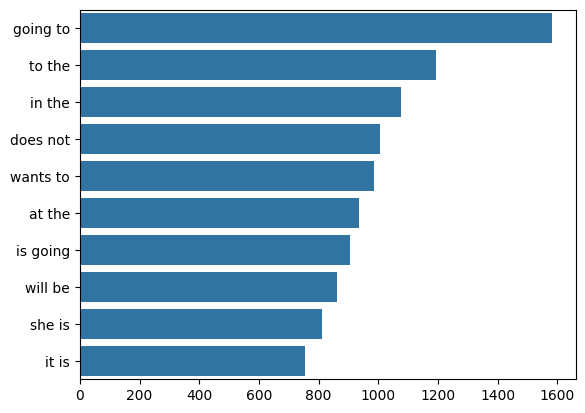

In [39]:
top_n_bigrams=get_top_ngram(df["summary"],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`

<Axes: >

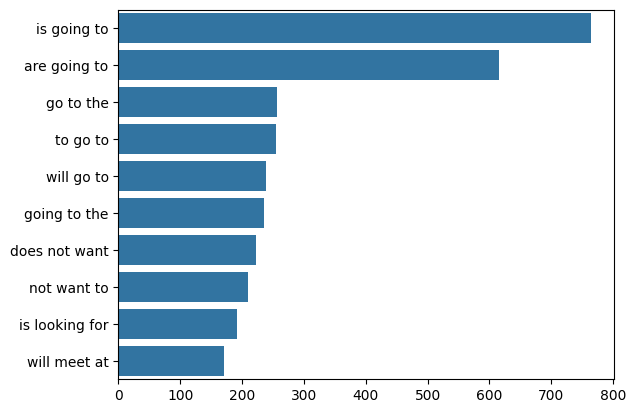

In [40]:
top_n_bigrams=get_top_ngram(df["summary"],3)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

In [41]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksimotabudjifupa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ksimotabudjifupa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ksimotabudjifupa\AppData\Roaming\nltk_data...


True

In [44]:
corpus=preprocess_summary(df,stop)

In [45]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [46]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.012*"going" + 0.009*"want" + 0.009*"meet" + 0.009*"come" + 0.008*"party" + 0.006*"tomorrow" + 0.006*"last" + 0.006*"back" + 0.005*"sam" + 0.005*"night"'),
 (1,
  '0.011*"new" + 0.011*"want" + 0.010*"like" + 0.009*"going" + 0.008*"peter" + 0.006*"work" + 0.006*"think" + 0.006*"job" + 0.005*"would" + 0.005*"one"'),
 (2,
  '0.015*"going" + 0.013*"want" + 0.008*"john" + 0.007*"meet" + 0.007*"week" + 0.007*"tom" + 0.006*"car" + 0.006*"take" + 0.006*"today" + 0.006*"next"'),
 (3,
  '0.009*"kate" + 0.007*"tomorrow" + 0.007*"need" + 0.006*"going" + 0.005*"want" + 0.005*"work" + 0.005*"class" + 0.005*"day" + 0.005*"sent" + 0.005*"david"')]

In [15]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
#vis

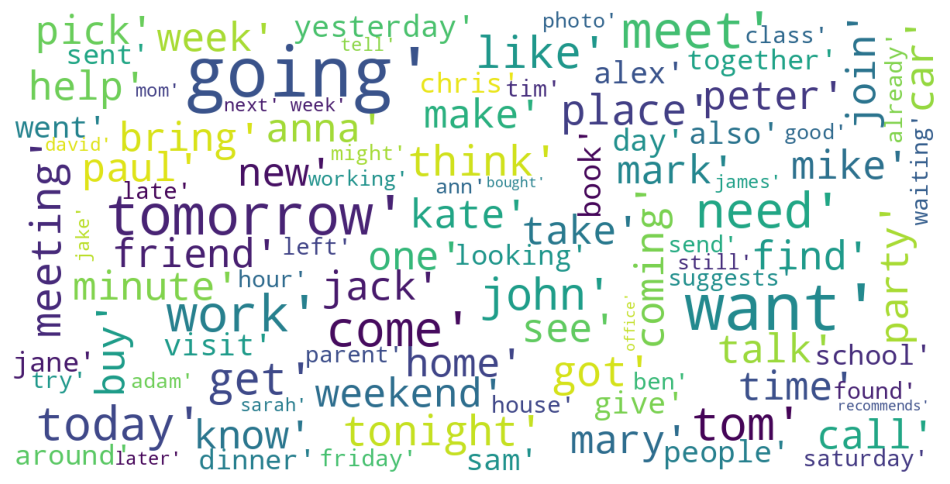

In [47]:
stopwords = set(STOPWORDS)
show_wordcloud(corpus)

#### Dialogues analysis

In [48]:
corpus=[]
new= df['dialogue'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

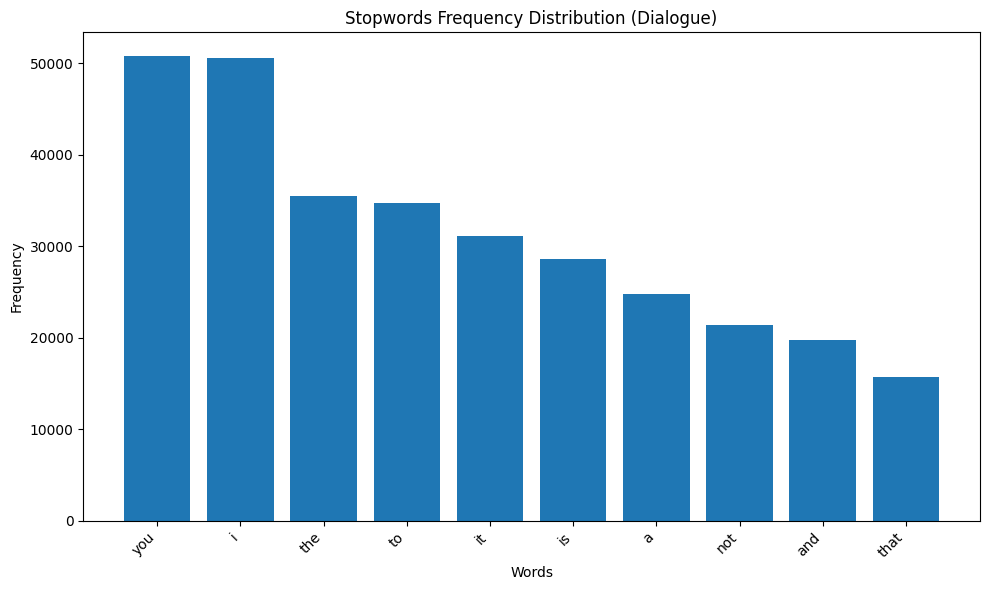

In [49]:
# Extract words and counts as separate lists
words = list(dic.keys())
counts = list(dic.values())

sorted_data = sorted(zip(words, counts), key=lambda x: x[1], reverse=True)
words, counts = zip(*sorted_data)

# Limit the number of words to plot (optional)
max_words_to_plot = 10  # You can adjust this value

words = words[:max_words_to_plot]
counts = counts[:max_words_to_plot]

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Stopwords Frequency Distribution (Dialogue)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`

<Axes: >

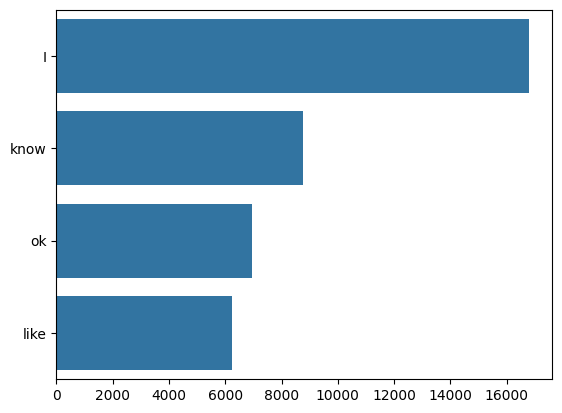

In [50]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
C:\Users\ksimotabudjifupa\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`

<Axes: >

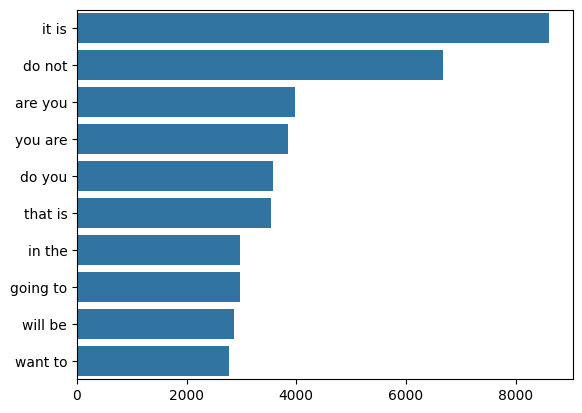

In [51]:
top_n_bigrams=get_top_ngram(df["dialogue"],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x) 

In [57]:
corpus = preprocess_dialogue(df,stop)

In [58]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [59]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.011*"know" + 0.009*"john" + 0.008*"like" + 0.007*"kate" + 0.007*"good" + 0.007*"time" + 0.006*"would" + 0.006*"think" + 0.006*"see" + 0.006*"yeah"'),
 (1,
  '0.012*"know" + 0.009*"mark" + 0.008*"anna" + 0.007*"like" + 0.007*"good" + 0.006*"sure" + 0.006*"time" + 0.006*"would" + 0.006*"really" + 0.006*"thanks"'),
 (2,
  '0.011*"know" + 0.009*"tom" + 0.008*"yeah" + 0.008*"like" + 0.007*"one" + 0.007*"yes" + 0.006*"time" + 0.006*"think" + 0.006*"would" + 0.006*"chris"'),
 (3,
  '0.010*"know" + 0.008*"like" + 0.007*"peter" + 0.007*"alex" + 0.007*"going" + 0.007*"get" + 0.007*"yes" + 0.006*"would" + 0.006*"good" + 0.006*"see"')]

In [ ]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
#vis

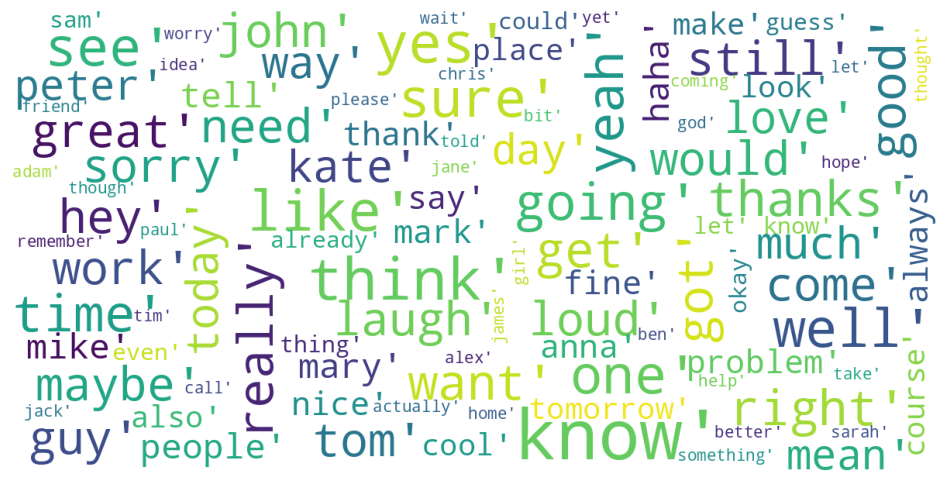

In [60]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)